## Spartans_AI-Classifican-Model-for-Diabetic-Retinopathy--DR-
- Tauha Imran
- Moaz Farooq
- Sarim Rasheed

In [ ]:
# ONLY RUN IF DATA NOT DOWNLOADED!!!
# RUN THIS CELL ONLY ONCE!!!

#if dependency issue
# pip install kagglehub

# Importing TensorFlow - dataset
import kagglehub
# Download latest version
path = kagglehub.dataset_download("kushagratandon12/diabetic-retinopathy-balanced")

print("Path to dataset files:", path)

100%|██████████| 1.90G/1.90G [00:11<00:00, 179MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1


The actual model training code

In [ ]:
#imports:


# Importing TensorFlow
import tensorflow as tf

# Importing PyTorch
import torch

# Importing OpenCV
import cv2

# Importing FastAI
from fastai.vision.all import *

# Importing Scikit-Learn
import sklearn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input  # Import preprocessing
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import cv2

print('testing')


testing


In [ ]:
# checking data:

import os

dataset_path = "/root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1"

if os.path.exists(dataset_path):
    print("Dataset found!")
    print("Files:", os.listdir(dataset_path))
else:
    print("Dataset not found. Check the extraction process.")


Dataset found!
Files: ['content']


In [ ]:
# getting data:

from google.colab import drive
import shutil

drive.mount('/content/drive')

destination_path = "/content/drive/MyDrive/diabetic-retinopathy-dataset"
shutil.copytree(dataset_path, destination_path)

print("Dataset copied to Google Drive successfully!")




Mounted at /content/drive
Dataset copied to Google Drive successfully!


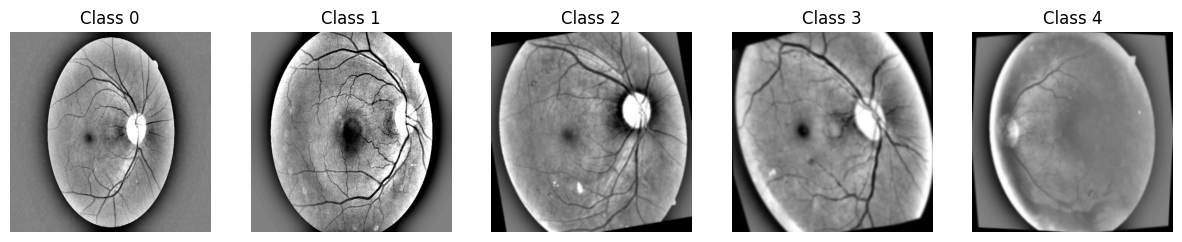



 Data Acquired 


-------------------------------------------------------------------------------


In [ ]:

import matplotlib.pyplot as plt

# Corrected base dataset path
base_path = "/content/drive/MyDrive/diabetic-retinopathy-dataset/content/Diabetic_Balanced_Data"

# Dataset splits
splits = ["train", "test", "val"]  # Change as needed

# Number of classes
classes = ["0", "1", "2", "3", "4"]

# Select split (change to "test" or "val" if needed)
split = "train"

# Dictionary to store sample images
sample_images = {}

# Load one image per class
for cls in classes:
    class_path = os.path.join(base_path, split, cls)  # Path to class folder

    # Check if the class folder exists
    if not os.path.exists(class_path):
        print(f"Warning: Class folder {class_path} not found!")
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if images:  # Ensure folder is not empty
        img_path = os.path.join(class_path, images[0])  # Get the first image
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        sample_images[cls] = img

# Plot the images
plt.figure(figsize=(15, 5))
for i, (cls, img) in enumerate(sample_images.items()):
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(img)
    plt.title(f"Class {cls}")
    plt.axis("off")

plt.show()
print("\n\n Data Acquired \n\n")
print("-------------------------------------------------------------------------------")


In [ ]:
#VGG16


# Paths to dataset folders
train_dir = "/content/drive/MyDrive/diabetic-retinopathy-dataset/content/Diabetic_Balanced_Data/train"
test_dir = "/content/drive/MyDrive/diabetic-retinopathy-dataset/content/Diabetic_Balanced_Data/test"

# Enable mixed precision for speedup
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print('Mixed precision enabled')
except:
    pass

# Enable XLA Compilation for Speedup
tf.config.optimizer.set_jit(True)

# Define image size and batch size
image_size = (224, 224)
batch_size = 32  # Reduce if running into VRAM issues

# Data augmentation with proper VGG16 preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Use VGG16 preprocessing
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Ensure grayscale images are loaded as 3-channel tensors
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'  # Explicitly convert grayscale to 3 channels
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

num_classes = train_generator.num_classes

# Load pre-trained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze layers

# Custom classifier remains the same
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax', dtype=tf.float32)(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy')
]

# Training steps
train_steps = train_generator.samples // batch_size
valid_steps = test_generator.samples // batch_size

# Initial training
history = model.fit(
    train_generator,
    epochs=15,
    steps_per_epoch=train_steps,
    validation_data=test_generator,
    validation_steps=valid_steps,
    callbacks=callbacks
)

# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:15]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    epochs=15,
    steps_per_epoch=train_steps,
    validation_data=test_generator,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Mixed precision enabled
Found 34792 images belonging to 5 classes.
Found 4971 images belonging to 5 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.3778 - loss: 1.7594 - precision: 0.4101 - recall: 0.2944

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 745s 667ms/step - accuracy: 0.3778 - loss: 1.7592 - precision: 0.4102 - recall: 0.2944 - val_accuracy: 0.5363 - val_loss: 1.1042 - val_precision: 0.6167 - val_recall: 0.3808 - learning_rate: 1.0000e-04
Epoch 2/15
   1/1087 ━━━━━━━━━━━━━━━━━━━━ 1:30 83ms/step - accuracy: 0.4062 - loss: 1.5170 - precision: 0.5263 - recall: 0.3125

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1087/1087 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.4062 - loss: 1.5170 - precision: 0.5263 - recall: 0.3125 - val_accuracy: 0.5377 - val_loss: 1.1037 - val_precision: 0.6181 - val_recall: 0.3825 - learning_rate: 1.0000e-04
Epoch 3/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 680s 608ms/step - accuracy: 0.4454 - loss: 1.3719 - precision: 0.5018 - recall: 0.3430 - val_accuracy: 0.5292 - val_loss: 1.1071 - val_precision: 0.6136 - val_recall: 0.3714 - learning_rate: 1.0000e-04
Epoch 4/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.4688 - loss: 1.5646 - precision: 0.5000 - recall: 0.4375 - val_accuracy: 0.5300 - val_loss: 1.1070 - val_precision: 0.6128 - val_recall: 0.3714 - learning_rate: 1.0000e-04
Epoch 5/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.4732 - loss: 1.2727 - precision: 0.5334 - recall: 0.3567

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 681s 590ms/step - accuracy: 0.4732 - loss: 1.2726 - precision: 0.5334 - recall: 0.3567 - val_accuracy: 0.5546 - val_loss: 1.0668 - val_precision: 0.6416 - val_recall: 0.3909 - learning_rate: 2.0000e-05
Epoch 6/15
   1/1087 ━━━━━━━━━━━━━━━━━━━━ 1:19 73ms/step - accuracy: 0.5000 - loss: 1.2910 - precision: 0.5500 - recall: 0.3438

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - accuracy: 0.5000 - loss: 1.2910 - precision: 0.5500 - recall: 0.3438 - val_accuracy: 0.5550 - val_loss: 1.0672 - val_precision: 0.6414 - val_recall: 0.3913 - learning_rate: 2.0000e-05
Epoch 7/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.4837 - loss: 1.2374 - precision: 0.5460 - recall: 0.3684

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 607s 551ms/step - accuracy: 0.4837 - loss: 1.2374 - precision: 0.5460 - recall: 0.3684 - val_accuracy: 0.5593 - val_loss: 1.0599 - val_precision: 0.6466 - val_recall: 0.3940 - learning_rate: 2.0000e-05
Epoch 8/15
   1/1087 ━━━━━━━━━━━━━━━━━━━━ 1:11 66ms/step - accuracy: 0.5000 - loss: 1.1738 - precision: 0.5833 - recall: 0.4375

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.5000 - loss: 1.1738 - precision: 0.5833 - recall: 0.4375 - val_accuracy: 0.5595 - val_loss: 1.0610 - val_precision: 0.6462 - val_recall: 0.3940 - learning_rate: 2.0000e-05
Epoch 9/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 619s 569ms/step - accuracy: 0.4891 - loss: 1.2209 - precision: 0.5555 - recall: 0.3711 - val_accuracy: 0.5520 - val_loss: 1.0685 - val_precision: 0.6380 - val_recall: 0.3919 - learning_rate: 2.0000e-05
Epoch 10/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.2812 - loss: 1.5273 - precision: 0.4000 - recall: 0.2500 - val_accuracy: 0.5514 - val_loss: 1.0676 - val_precision: 0.6389 - val_recall: 0.3923 - learning_rate: 4.0000e-06
Epoch 11/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 621s 542ms/step - accuracy: 0.4955 - loss: 1.2039 - precision: 0.5656 - recall: 0.3761 - val_accuracy: 0.5554 - val_loss: 1.0536 - val_precision: 0.6431 - val_recall: 0.4010 - learning_rate: 4.0000e-06
Epoch 12/15
1087/1087 ━━━━━━━━━━━━━━━

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 621s 561ms/step - accuracy: 0.5100 - loss: 1.1696 - val_accuracy: 0.5786 - val_loss: 0.9728 - learning_rate: 1.0000e-05
Epoch 2/15
   1/1087 ━━━━━━━━━━━━━━━━━━━━ 1:26 80ms/step - accuracy: 0.5000 - loss: 1.1331

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - accuracy: 0.5000 - loss: 1.1331 - val_accuracy: 0.5794 - val_loss: 0.9721 - learning_rate: 1.0000e-05
Epoch 3/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 612s 562ms/step - accuracy: 0.5389 - loss: 1.0979 - val_accuracy: 0.4986 - val_loss: 1.2301 - learning_rate: 1.0000e-05
Epoch 4/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.4062 - loss: 1.2986 - val_accuracy: 0.4992 - val_loss: 1.2299 - learning_rate: 1.0000e-05
Epoch 5/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 682s 592ms/step - accuracy: 0.5470 - loss: 1.0728 - val_accuracy: 0.5734 - val_loss: 1.0218 - learning_rate: 2.0000e-06
Epoch 6/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5000 - loss: 1.1948 - val_accuracy: 0.5726 - val_loss: 1.0222 - learning_rate: 2.0000e-06
Epoch 7/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.5598 - loss: 1.0378

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 600s 552ms/step - accuracy: 0.5598 - loss: 1.0378 - val_accuracy: 0.5970 - val_loss: 0.9711 - learning_rate: 4.0000e-07
Epoch 8/15
   1/1087 ━━━━━━━━━━━━━━━━━━━━ 1:16 70ms/step - accuracy: 0.5312 - loss: 1.2611

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - accuracy: 0.5312 - loss: 1.2611 - val_accuracy: 0.5976 - val_loss: 0.9705 - learning_rate: 4.0000e-07
Epoch 9/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 596s 548ms/step - accuracy: 0.5581 - loss: 1.0414 - val_accuracy: 0.5948 - val_loss: 0.9692 - learning_rate: 4.0000e-07
Epoch 10/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.4688 - loss: 1.1642 - val_accuracy: 0.5958 - val_loss: 0.9688 - learning_rate: 4.0000e-07
Epoch 11/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.5624 - loss: 1.0351

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 644s 542ms/step - accuracy: 0.5624 - loss: 1.0351 - val_accuracy: 0.5990 - val_loss: 0.9632 - learning_rate: 4.0000e-07
Epoch 12/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.5938 - loss: 1.0125 - val_accuracy: 0.5988 - val_loss: 0.9634 - learning_rate: 4.0000e-07
Epoch 13/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 622s 571ms/step - accuracy: 0.5735 - loss: 1.0136 - val_accuracy: 0.5972 - val_loss: 0.9721 - learning_rate: 4.0000e-07
Epoch 14/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.6562 - loss: 0.7506 - val_accuracy: 0.5974 - val_loss: 0.9721 - learning_rate: 1.0000e-07
Epoch 15/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.5675 - loss: 1.0249

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 623s 573ms/step - accuracy: 0.5675 - loss: 1.0249 - val_accuracy: 0.5998 - val_loss: 0.9665 - learning_rate: 1.0000e-07


In [ ]:
# === NEW CODE ADDED HERE ===
# Save final weights after all training
#model.save_weights('final_weights.h5')  # Saves weights only
model.save('full_model.h5')  # Alternative: Saves entire model (architecture + weights + optimizer state)
# When saving your model
model.save('full_model.keras', save_format='keras')

print("Training complete. Model weights saved as 'final_weights.h5'")

Training complete. Model weights saved as 'final_weights.h5'


In [ ]:
# summary:

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_22 (Cast)                       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 47,755,088 (182.17 MB)

 Trainable params: 20,059,141 (76.52 MB)

 Non-trainable params: 7,636,800 (29.13 MB)

 Optimizer params: 20,059,147 (76.52 MB)

Upload file into model... 


FileUpload(value={}, accept='image/*', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


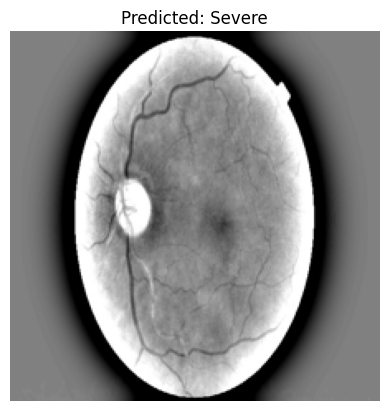

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


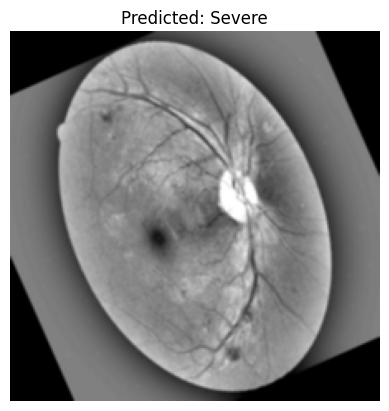

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


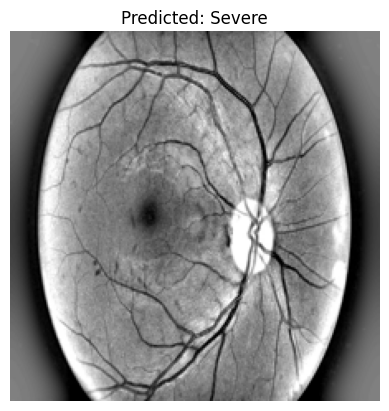

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


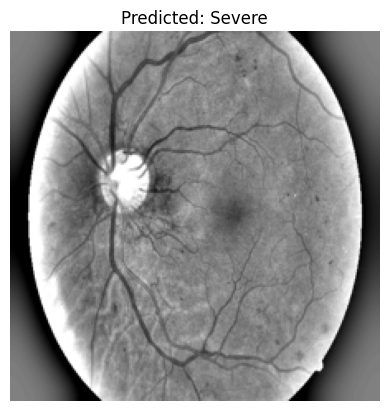

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import ipywidgets as widgets
from tensorflow.keras.preprocessing import image
from IPython.display import display
from PIL import Image
import torch

# Load your trained model
# Update this path to match the location of your saved .h5 file
#MODEL_PATH = "/content/trained_model.h5"  # Change if using PyTorch or 'full_model.keras'
MODEL_PATH = "/content/trained_model.keras"  # Change if using PyTorch or 'full_model.keras'
model = tf.keras.models.load_model(MODEL_PATH)

# Class labels
CLASS_LABELS = ["No DR", "Mild", "Moderate", "Severe", "Proliferative"]

print("Upload file into model... ")
# Image upload widget
upload = widgets.FileUpload(accept='image/*', multiple=False)

def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))  # Adjust based on model input size
    img_array = np.array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

def classify_image(change):
    for name, file_info in upload.value.items():
        with open(name, 'wb') as f:
            f.write(file_info['content'])

        # Preprocess image
        img, img_array = preprocess_image(name)

        # Make prediction
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions)

        # Show image and result
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {CLASS_LABELS[predicted_class]}")
        plt.show()

upload.observe(classify_image, names='value')
display(upload)